In [ ]:
# Block 1: Imports and Initial Setup
import os
import json
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Configure GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Audio config
SR = 22050
DURATION = 10
SAMPLES_PER_TRACK = SR * DURATION
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 1723  # ~130 time steps
BATCH_SIZE = 64

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Block 2: Data Loading and Preprocessing
def load_dataset(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    X = np.array(data['mfcc'])
    y = np.array(data['labels'])
    X = X[..., np.newaxis]

    return X, y, data['mapping']

JSON_PATH = "/content/drive/MyDrive/ArabicClips/Finaldata.json"
X, y, genre_names = load_dataset(JSON_PATH)
y_onehot = tf.keras.utils.to_categorical(y)

In [ ]:
# Block 3: Data Splitting and Dataset Creation
# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, stratify=y_onehot, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

def create_dataset(X, y, batch_size=BATCH_SIZE, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(X_train, y_train, shuffle=True)
val_dataset = create_dataset(X_val, y_val)
test_dataset = create_dataset(X_test, y_test)

In [ ]:
# Block 4: Model Definition
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:], padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(genre_names), activation='softmax')
])

# Class weights
y_labels = np.argmax(y_onehot, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 130, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 130, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 65, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 65, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,397 (2.36 MB)

 Trainable params: 618,949 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Block 5: Training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/ArMGC_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stop]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3462 - loss: 2.3310
Epoch 1: val_accuracy improved from -inf to 0.48156, saving model to /content/drive/MyDrive/ArMGC_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.3469 - loss: 2.3256 - val_accuracy: 0.4816 - val_loss: 1.1702
Epoch 2/50
135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6038 - loss: 1.0503
Epoch 2: val_accuracy improved from 0.48156 to 0.61802, saving model to /content/drive/MyDrive/ArMGC_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6049 - loss: 1.0477 - val_accuracy: 0.6180 - val_loss: 1.2376
Epoch 3/50
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7108 - loss: 0.8055
Epoch 3: val_accuracy improved from 0.61802 to 0.62487, saving model to /content/drive/MyDrive/ArMGC_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7109 - loss: 0.8050 - val_accuracy: 0.6249 - val_loss: 1.3901
Epoch 4/50
136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9547 - loss: 0.1626

✅ Test Accuracy: 95.52%
📝 Test Loss: 0.1849
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:
              precision    recall  f1-score   support

        east       0.97      0.95      0.96       437
       loyal       0.95      0.94      0.94       437
        Muwa       0.90      0.95      0.93       376
       poems       0.98      0.98      0.98       480
         rai       0.99      0.94      0.97       169

    accuracy                           0.96      1899
   macro avg       0.96      0.95      0.96      1899
weighted avg       0.96      0.96      0.96      1899



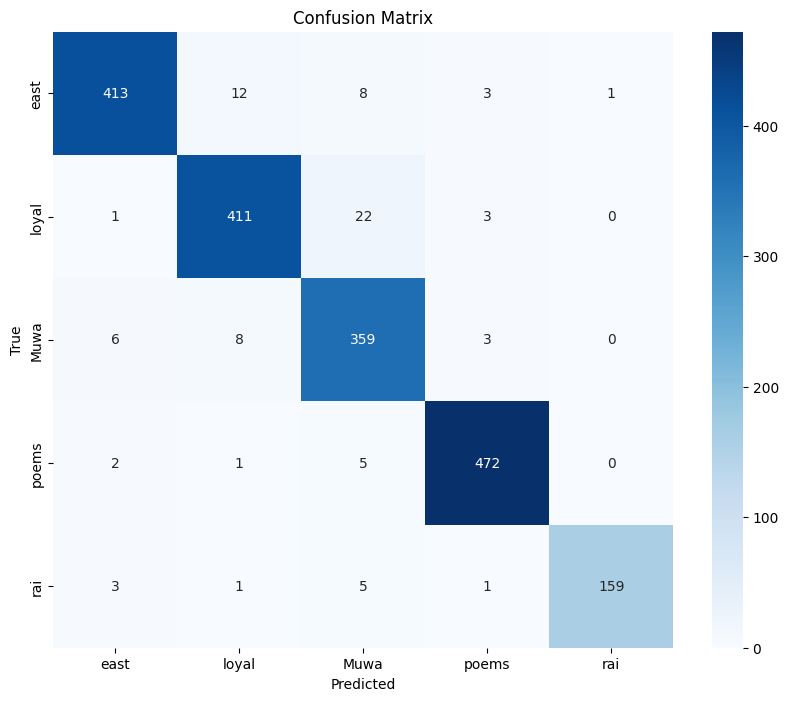

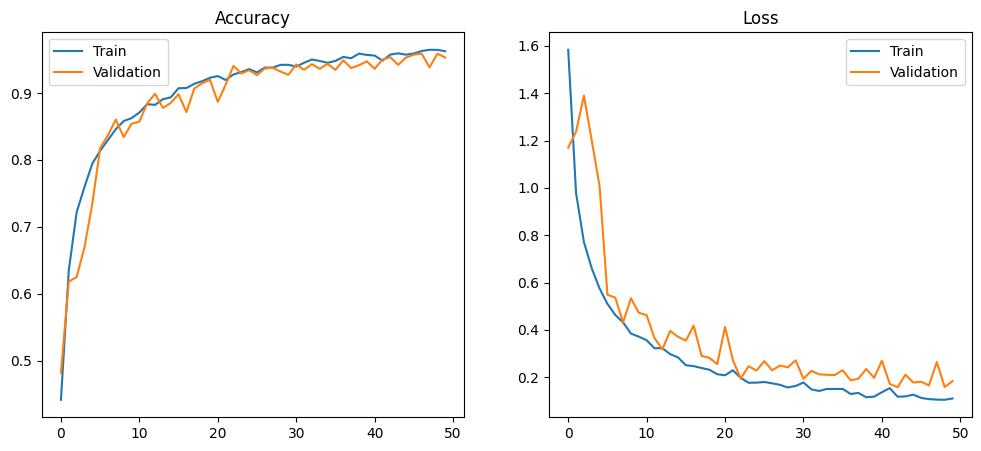

In [ ]:
# Block 6: Evaluation and Results
# Load best saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/ArMGC_model.keras')

# Test evaluation
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_acc:.2%}")
print(f"📝 Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=genre_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
# Save as HDF5
model.save("/content/drive/MyDrive/arabic_music_genre_model.keras")


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/arabic_music_genre_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(genre_names)

['east', 'loyal', 'Muwa', 'poems', 'rai']
